In [2]:
# -------- helpers robustes --------
def make_X(df, cols):
    X = df[cols].copy()
    for c in cols:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    X = X.replace([np.inf, -np.inf], np.nan).fillna(method="ffill").fillna(0.0)
    return X

def align_xy(X, y):
    m = ~np.isnan(y)
    return X.loc[m], y[m]

# ===== Exp A: Tabulaire pur =====
Xcols_A = pick_existing(df, CANDIDATES)
if not Xcols_A:
    raise ValueError("Aucune feature tabulaire trouvée.")

ytr = train[TARGET].astype(float).to_numpy()
yte = test[TARGET].astype(float).to_numpy()

Xtr_A = make_X(train, Xcols_A)
Xte_A = make_X(test,  Xcols_A)
Xtr_A, ytr = align_xy(Xtr_A, ytr)

rfA = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1).fit(Xtr_A, ytr)
predA = rfA.predict(Xte_A)
mA = evaluate(yte, predA, tag="A_Tabular")

# ===== Exp B: Tabulaire + Graph/BIM =====
Xcols_B = Xcols_A + pick_existing(df, BIM_COLS)
static_graph = graph_bim_features(TTL)
trainB = attach_static_features(train.copy(), static_graph)
testB  = attach_static_features(test.copy(),  static_graph)
for k in static_graph:
    if k not in Xcols_B:
        Xcols_B.append(k)

Xtr_B = make_X(trainB, Xcols_B)
Xte_B = make_X(testB,  Xcols_B)
Xtr_B, ytr = align_xy(Xtr_B, ytr)  # réaligner au cas où

rfB = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1).fit(Xtr_B, ytr)
predB = rfB.predict(Xte_B)
mB = evaluate(yte, predB, tag="B_Tabular+GraphBIM")

lin = Ridge(alpha=1.0).fit(Xtr_B, ytr)
predL = lin.predict(Xte_B)
mL = evaluate(yte, predL, tag="Baseline_Ridge_B")


NameError: name 'df' is not defined

Target = s_power_total_kw
                    Model       MAE      RMSE        R2
0  RandomForest (tabular)  0.189546  0.269715  0.970318
1         Ridge (tabular)  0.265547  0.344642  0.951536
Saved: /home/amina/DTE/jne_project/model/tabular/prelim_results_tabular.csv and /home/amina/DTE/jne_project/model/tabular/prelim_predictions.png


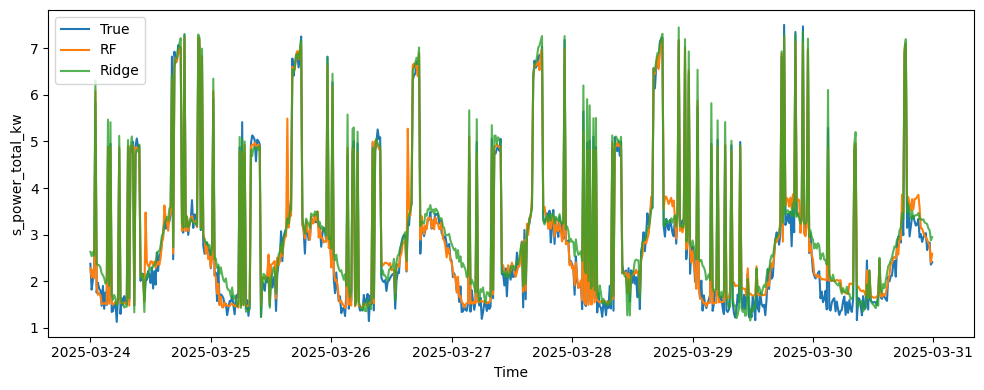

In [5]:
# === Preliminary Experiments: Tabular baselines (RF, Ridge) + optional BIM features from TTL ===
from pathlib import Path
import math, warnings, numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# ---- Paths (adapt if needed) ----
BASE = Path.home() / "DTE" / "jne_project"
CSV  = BASE / "model" / "tabular" / "ai_ready_with_bim.csv"   # fourni
TTL  = BASE / "graph" / "edtb_graph.ttl"                      # optionnel

# ---- Load CSV (UTC, tri, nettoyage) ----
def load_tabular(p: Path) -> pd.DataFrame:
    df = pd.read_csv(p, parse_dates=["ts"])
    if df["ts"].dt.tz is None: df["ts"] = df["ts"].dt.tz_localize("UTC")
    else: df["ts"] = df["ts"].dt.tz_convert("UTC")
    df = df.sort_values("ts").reset_index(drop=True)
    return df

df = load_tabular(CSV)

# ---- Choose target automatically (override if needed) ----
candidates_tgt = [
    "s_power_total_kw", "P_total", "P_hvac", "Room_101_temp_int_c",
    "s_temp_int_c", "T_int", "T_int_true"
]
TARGET = next((c for c in candidates_tgt if c in df.columns), None)
if TARGET is None:
    raise ValueError(f"Aucune cible trouvée. Colonnes dispo:\n{list(df.columns)}")

# ---- Feature set: all numeric except {ts, zone_id, target} ----
drop_cols = {"ts", "zone_id", TARGET}
Xcols = [c for c in df.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(df[c])]
if not Xcols: 
    raise ValueError("Aucune feature numérique. Vérifie le CSV.")

# ---- Optional: add constant BIM/meta from TTL if present ----
def graph_bim_meta(ttl_path: Path) -> dict:
    try:
        from rdflib import Graph, Namespace, Literal
        g = Graph(); g.parse(ttl_path, format="turtle")
        EX = Namespace("http://example.org/training#")
        room = EX.Room_101
        feats = {}
        for p,o in g.predicate_objects(room):
            if isinstance(o, Literal):
                key = "bim_" + (str(p).split("#")[-1])
                try: feats[key] = float(o)
                except: feats[key] = str(o)
        # exemples simples sur éléments
        for k in ["Wall_North","Window1"]:
            node = getattr(EX, k)
            if (node, None, None) in g:
                for p,o in g.predicate_objects(node):
                    if isinstance(o, Literal):
                        key = f"bim_{k}__{str(p).split('#')[-1]}"
                        try: feats[key] = float(o)
                        except: feats[key] = str(o)
        return feats
    except Exception as e:
        print("[TTL] Ignoré:", e); return {}

static_feats = graph_bim_meta(TTL) if TTL.exists() else {}
for k,v in static_feats.items():
    if k not in df.columns and isinstance(v, (int,float)):  # colonnes constantes utiles
        df[k] = float(v)
        Xcols.append(k)

# ---- Time split: last 7 days for test ----
def time_split_index(dff, test_days=7):
    tmax = dff["ts"].max().normalize()
    tmin = tmax - pd.Timedelta(days=test_days-1)
    idx = dff.index[dff["ts"] >= tmin].min()
    return int(idx) if pd.notna(idx) else int(0.8*len(dff))

i_split = time_split_index(df, test_days=7)
train, test = df.iloc[:i_split].copy(), df.iloc[i_split:].copy()

# ---- Build X/y with robust numeric cleaning ----
def make_Xy(dff, feats, target):
    X = dff[feats].apply(pd.to_numeric, errors="coerce").replace([np.inf,-np.inf], np.nan).fillna(method="ffill").fillna(0.0)
    y = pd.to_numeric(dff[target], errors="coerce").to_numpy()
    m = ~np.isnan(y);  X = X.loc[m]; y = y[m]
    return X, y

Xtr, ytr = make_Xy(train, Xcols, TARGET)
Xte, yte = make_Xy(test,  Xcols, TARGET)

# ---- Models ----
warnings.filterwarnings("ignore")

rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1).fit(Xtr, ytr)
yhat_rf = rf.predict(Xte)

ridge = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=1.0))  # robuste si features constantes
ridge.fit(Xtr, ytr)
yhat_rg = ridge.predict(Xte)

# ---- Metrics ----
def metrics(y, yhat):
    mae  = mean_absolute_error(y, yhat)
    rmse = math.sqrt(mean_squared_error(y, yhat))
    r2   = r2_score(y, yhat)
    return mae, rmse, r2

mae_rf, rmse_rf, r2_rf = metrics(yte, yhat_rf)
mae_rg, rmse_rg, r2_rg = metrics(yte, yhat_rg)

res = pd.DataFrame({
    "Model": ["RandomForest (tabular)", "Ridge (tabular)"],
    "MAE":   [mae_rf, mae_rg],
    "RMSE":  [rmse_rf, rmse_rg],
    "R2":    [r2_rf,  r2_rg]
})
out_dir = BASE / "model" / "tabular"
out_dir.mkdir(parents=True, exist_ok=True)
res_path = out_dir / "prelim_results_tabular.csv"
res.to_csv(res_path, index=False)

print(f"Target = {TARGET}")
print(res)

# ---- Plot (enregistre PNG) ----
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(test.loc[Xte.index, "ts"], yte, label="True")
plt.plot(test.loc[Xte.index, "ts"], yhat_rf, label="RF")
plt.plot(test.loc[Xte.index, "ts"], yhat_rg, label="Ridge", alpha=0.8)
#plt.title(f"Preliminary prediction — Target: {TARGET}")
plt.xlabel("Time"); plt.ylabel(TARGET); plt.legend(loc="best")
png_path = out_dir / "prelim_predictions.png"
plt.tight_layout(); plt.savefig(png_path, dpi=150)
print("Saved:", res_path, "and", png_path)
